# Table of Contents

* TABLE OF CONTENTS
* IMPORTS
* INTRODUCTION
* CONFIGURATION
* CONFIGURATION PARAMETERS
* DATASET COLUMNS
* PREPROCESSING
* ADVERSARIAL CV
* EDA AND VISUALS
* TARGET PLOTS
* PAIR-PLOTS
* CATEGORY COLUMN PLOTS
* CONTINUOUS COLUMN ANALYSIS
* DUPLICATES ANALYSIS
* UNIVARIATE ANALYSIS AND FEATURE RELATIONS
* DATA TRANSFORMS
* MODEL TRAINING
* ENSEMBLE AND SUBMISSION
* PLANNED WAY FORWARD

# Imports

In [1]:
%%time

# General library imports:-
# !pip install --upgrade scipy;

import pandas as pd;
import numpy as np;
from scipy.stats import mode, kstest, normaltest, shapiro, anderson, jarque_bera;
from collections import Counter;
from itertools import product;
from colorama import Fore, Style, init;
from warnings import filterwarnings;
filterwarnings('ignore');

from tqdm.notebook import tqdm;
from IPython.display import clear_output;

import seaborn as sns;
import matplotlib.pyplot as plt;
from gc import collect;
from pprint import pprint;

pd.set_option('display.max_columns', 50);
pd.set_option('display.max_rows', 50);

# Setting rc parameters in seaborn for plots and graphs- 
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.85,  
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'tab:blue',
         'axes.titlesize'       : 9.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 8.0,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,        
        });

print();
collect();
clear_output();

CPU times: total: 125 ms
Wall time: 1.16 s


In [2]:
%%time 

# Importing model and pipeline specifics:-

# Pipeline specifics:-
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler;
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF, 
                                     StratifiedKFold as SKF,
                                     KFold, 
                                     RepeatedKFold as RKF, 
                                     cross_val_score);
from sklearn.inspection import permutation_importance, PartialDependenceDisplay as PDD;
from sklearn.feature_selection import mutual_info_regression, RFE;
from sklearn.pipeline import Pipeline;
from sklearn.base import BaseEstimator, TransformerMixin;

# ML Model training:-
from sklearn.metrics import mean_absolute_error as mae, r2_score;
from sklearn.svm import SVR;
from xgboost import XGBRegressor;
from lightgbm import LGBMClassifier, LGBMRegressor, log_evaluation;
from catboost import CatBoostRegressor;
from sklearn.ensemble import (RandomForestRegressor as RFR,
                              ExtraTreesRegressor as ETR,
                              GradientBoostingRegressor as GBR,
                              HistGradientBoostingRegressor as HGBR
                             );
from sklearn.linear_model import Ridge, Lasso;

# Ensemble creation:-
# !pip install -q scikit-lego;
from sklego.linear_model import LADRegression as LADR;

from sklearn import set_config; 
set_config(transform_output = "pandas");

clear_output();
print();
collect();


CPU times: total: 31.2 ms
Wall time: 362 ms


# Configuration

In [3]:
%%time

# Configuration class:-
class CFG:
    "Configuration class for parameters and CV strategy for tuning and training";
    
    # Data preparation:-   
    version_nb         = 5;
    test_req           = "N";
    gpu_switch         = "OFF"; 
    state              = 42;
    target             = "Age";
    episode            = 16;
    path               = f"C:/Users/Emincan/Desktop/Playground/";
    orig_path          = f"C:/Users/Emincan/Desktop/Playground/CrabAgePrediction.csv";
    adv_cv_req         = "Y";
    ftre_plots_req     = "Y";
    ftre_imp_req       = "N";
    
    # Data transforms and scaling:-    
    conjoin_orig_data  = "Y";
    sec_ftre_req       = "Y";
    scale_req          = "N";
    # NOTE---Keep a value here even if scale_req = N, this is used for linear models:-
    scl_method         = "Z"; 
    
    # Model Training:- 
    baseline_req       = "N";
    pstprcs_oof        = "Y";
    pstprcs_train      = "N";
    ML                 = "Y";
    use_orig_allfolds  = "N";
    n_splits           = 10 ;
    n_repeats          = 1 ;
    nbrnd_erly_stp     = 200 ;
    mdlcv_mthd         = 'RSKF';
    
    # Ensemble:-    
    ensemble_req       = "Y";
    enscv_mthd         = "RSKF";
    neg_wgt            = False;
    metric_obj         = 'minimize';
    
    # Global variables for plotting:-
    grid_specs = {'visible': True, 'which': 'both', 'linestyle': '--', 
                           'color': 'lightgrey', 'linewidth': 0.75};
    title_specs = {'fontsize': 9, 'fontweight': 'bold', 'color': 'tab:blue'};

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL); 

# Scaler to be used for continuous columns:- 
all_scalers = {'Robust': RobustScaler(), 
               'Z': StandardScaler(), 
               'MinMax': MinMaxScaler()
              };
scaler      = all_scalers.get(CFG.scl_method);

# Commonly used CV strategies for later usage:-
all_cv= {'KF'  : KFold(n_splits= CFG.n_splits, shuffle = True, random_state= CFG.state),
         'RKF' : RKF(n_splits= CFG.n_splits, n_repeats = CFG.n_repeats, random_state= CFG.state),
         'RSKF': RSKF(n_splits= CFG.n_splits, n_repeats = CFG.n_repeats, random_state= CFG.state),
         'SKF' : SKF(n_splits= CFG.n_splits, shuffle = True, random_state= CFG.state)
        };

# Defining the competition metric:-
def ScoreMetric(ytrue, ypred):
    """
    This function calculates the metric for the competition. 
    ytrue- ground truth array
    ypred- predictions
    returns - metric value (float)
    """;
    return mae(ytrue, ypred);

print();
PrintColor(f"--> Configuration done!");
collect();


--> Configuration done!
CPU times: total: 31.2 ms
Wall time: 38.9 ms


# Configuration Parameters

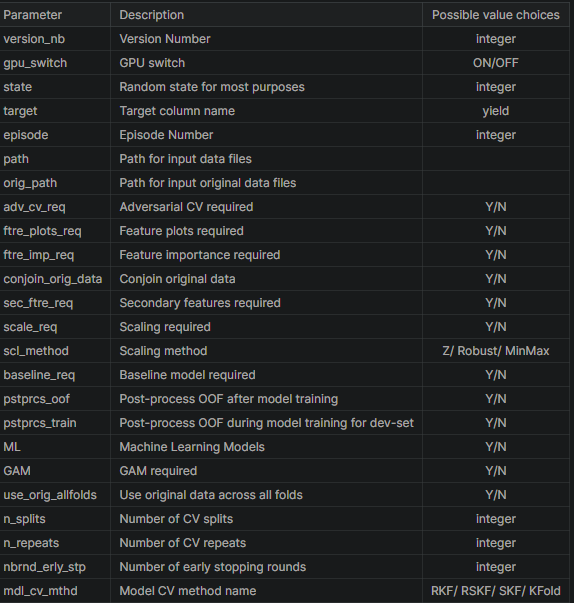

# Dataset and Competition Details

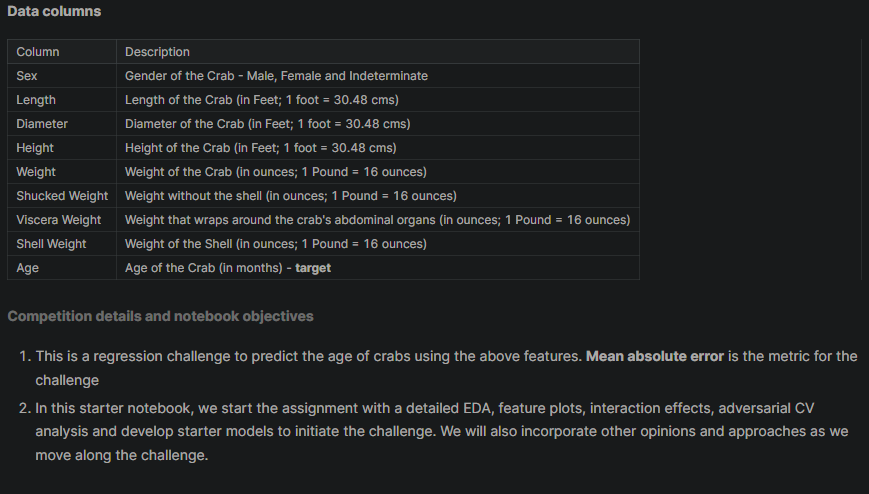

# Preprocessing

In [4]:
%%time

PrintColor(f"\n---------- Data Preprocessing ---------- \n", color = Fore.MAGENTA);

# Reading the train-test datasets:-
train    = pd.read_csv(CFG.path + f"train.csv", index_col = 'id');
test     = pd.read_csv(CFG.path + f"test.csv", index_col = 'id');
original = pd.read_csv(CFG.orig_path);

# Little Name Changes
train.rename(columns={'Shucked Weight' : 'ShuckedWeight' , 'Viscera Weight' : 'VisceraWeight' , 'Shell Weight' : 'ShellWeight'} , inplace = True) 
original.rename(columns={'Shucked Weight' : 'ShuckedWeight' , 'Viscera Weight' : 'VisceraWeight' , 'Shell Weight' : 'ShellWeight'} , inplace = True) 
test.rename(columns={'Shucked Weight' : 'ShuckedWeight' , 'Viscera Weight' : 'VisceraWeight' , 'Shell Weight' : 'ShellWeight'} , inplace = True) 

# Importing the sample submission file:-
sub_fl = pd.read_csv(CFG.path + f"sample_submission.csv");

if CFG.test_req == "Y":
    PrintColor(f"---> We are testing the code with 5% data sample", color = Fore.RED);
    train     = train.groupby([CFG.target]).sample(frac = 0.05);
    original  = original.groupby([CFG.target]).sample(frac = 0.05);
    test      = test.sample(frac = 0.05);
    sub_fl    = sub_fl.loc[sub_fl.id.isin(test.index)];
    
else: 
    PrintColor(f"---> We are not testing the code- this is an actual code run", color = Fore.RED);
    
original.index += max(test.index) + 1;
original.index.name = 'id';

# Replacing spaces in column names:-
for df in [train, test, original]: df.columns = df.columns.str.replace(r'\s+','');

train['Source'], test['Source'], original['Source'] = "Competition", "Competition", "Original";
PrintColor(f"\nData shapes- [train, test, original]-- {train.shape} {test.shape} {original.shape}\n");

# Creating dataset information:
PrintColor(f"\nTrain information\n");
display(train.info());
PrintColor(f"\nTest information\n")
display(test.info());
PrintColor(f"\nOriginal data information\n")
display(original.info());
print();

# Displaying column description:-
PrintColor(f"\nTrain description\n");
display(train.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).\
        transpose().\
        drop(columns = ['count'], errors = 'ignore').\
        drop([CFG.target], axis=0, errors = 'ignore').\
        style.format(precision = 2));

PrintColor(f"\nTest description\n");
display(test.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).\
        transpose().\
        drop(columns = ['count'], errors = 'ignore').\
        drop([CFG.target], axis=0, errors = 'ignore').\
        style.format(precision = 2));

PrintColor(f"\nOriginal description\n");
display(original.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).\
        transpose().\
        drop(columns = ['count'], errors = 'ignore').\
        drop([CFG.target], axis=0, errors = 'ignore').\
        style.format(precision = 2));

# Collating the column information:-
strt_ftre = test.columns;
PrintColor(f"\nStarting columns\n");
display(strt_ftre);

# Creating a copy of the datasets for further use:-
train_copy, test_copy, orig_copy = \
train.copy(deep= True), test.copy(deep = True), original.copy(deep = True);

# Dislaying the unique values across train-test-original:-
PrintColor(f"\nUnique values\n");
_ = pd.concat([train.nunique(), test.nunique(), original.nunique()], axis=1);
_.columns = ['Train', 'Test', 'Original'];
display(_.style.background_gradient(cmap = 'Blues').format(formatter = '{:,.0f}'));

# Normality check:-
cols = list(strt_ftre[1:-1]);
PrintColor(f"\nShapiro Wilk normality test analysis\n");
pprint({col: [np.round(shapiro(train[col]).pvalue,decimals = 4), 
              np.round(shapiro(test[col]).pvalue,4) if col != CFG.target else np.NaN,
              np.round(shapiro(original[col]).pvalue,4)] for col in cols
       }, indent = 5, width = 100, depth = 2, compact= True);

PrintColor(f"\nNormal-test normality test analysis\n");
pprint({col: [np.round(normaltest(train[col]).pvalue,decimals = 4), 
              np.round(normaltest(test[col]).pvalue,4) if col != CFG.target else np.NaN,
              np.round(normaltest(original[col]).pvalue,4)] for col in cols
       }, indent = 5, width = 100, depth = 2, compact= True);

PrintColor(f"\nK-S normality test analysis\n");
pprint({col: [np.round(kstest(train[col], cdf = 'norm').pvalue,decimals = 4), 
              np.round(kstest(test[col], cdf = 'norm').pvalue,4) if col != CFG.target else np.NaN,
              np.round(kstest(original[col], cdf = 'norm').pvalue,4)] for col in cols
       }, indent = 5, width = 100, depth = 2, compact= True);

# Encoding the sex column across datasets:-
sex_mapper     = {'I': 2, 'M': 0, 'F': 1};
inv_sex_mapper = {2: 'I', 0: "M", 1: "F"};

train['Sex'], test['Sex'], original['Sex'] = \
(train['Sex'].map(sex_mapper).astype(np.int8), 
 test['Sex'].map(sex_mapper).astype(np.int8), 
 original['Sex'].map(sex_mapper).astype(np.int8));

print();


---------- Data Preprocessing ---------- 

---> We are not testing the code- this is an actual code run

Data shapes- [train, test, original]-- (74051, 10) (49368, 9) (3893, 10)


Train information

<class 'pandas.core.frame.DataFrame'>
Index: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            74051 non-null  object 
 1   Length         74051 non-null  float64
 2   Diameter       74051 non-null  float64
 3   Height         74051 non-null  float64
 4   Weight         74051 non-null  float64
 5   ShuckedWeight  74051 non-null  float64
 6   VisceraWeight  74051 non-null  float64
 7   ShellWeight    74051 non-null  float64
 8   Age            74051 non-null  int64  
 9   Source         74051 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 6.2+ MB


None


Test information

<class 'pandas.core.frame.DataFrame'>
Index: 49368 entries, 74051 to 123418
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            49368 non-null  object 
 1   Length         49368 non-null  float64
 2   Diameter       49368 non-null  float64
 3   Height         49368 non-null  float64
 4   Weight         49368 non-null  float64
 5   ShuckedWeight  49368 non-null  float64
 6   VisceraWeight  49368 non-null  float64
 7   ShellWeight    49368 non-null  float64
 8   Source         49368 non-null  object 
dtypes: float64(7), object(2)
memory usage: 3.8+ MB


None


Original data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 123419 to 127311
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            3893 non-null   object 
 1   Length         3893 non-null   float64
 2   Diameter       3893 non-null   float64
 3   Height         3893 non-null   float64
 4   Weight         3893 non-null   float64
 5   ShuckedWeight  3893 non-null   float64
 6   VisceraWeight  3893 non-null   float64
 7   ShellWeight    3893 non-null   float64
 8   Age            3893 non-null   int64  
 9   Source         3893 non-null   object 
dtypes: float64(7), int64(1), object(2)
memory usage: 304.3+ KB


None



Train description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Length,1.32,0.29,0.19,0.74,1.15,1.38,1.54,1.62,1.68,1.79,2.01
Diameter,1.02,0.24,0.14,0.55,0.89,1.07,1.20,1.29,1.31,1.41,1.61
Height,0.35,0.09,0.00,0.19,0.30,0.36,0.41,0.45,0.47,0.53,2.83
Weight,23.39,12.65,0.06,3.60,13.44,23.80,32.16,39.14,44.21,53.44,80.10
ShuckedWeight,10.10,5.62,0.03,1.50,5.71,9.91,14.03,17.29,19.38,24.31,42.18
VisceraWeight,5.06,2.79,0.04,0.79,2.86,4.99,6.99,8.63,9.74,11.79,21.55
ShellWeight,6.72,3.58,0.04,1.11,3.97,6.93,9.07,11.30,12.74,15.68,28.49



Test description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Length,1.32,0.29,0.19,0.74,1.16,1.39,1.54,1.62,1.68,1.79,2.04
Diameter,1.03,0.24,0.14,0.56,0.89,1.07,1.20,1.29,1.31,1.41,1.62
Height,0.35,0.09,0.00,0.19,0.30,0.36,0.41,0.45,0.47,0.53,2.83
Weight,23.46,12.64,0.06,3.64,13.54,23.81,32.29,39.02,44.21,53.44,80.10
ShuckedWeight,10.13,5.61,0.03,1.55,5.74,9.98,14.05,17.29,19.26,24.39,42.18
VisceraWeight,5.07,2.79,0.01,0.81,2.88,4.99,7.02,8.63,9.72,11.85,21.55
ShellWeight,6.75,3.58,0.04,1.13,3.97,6.95,9.17,11.20,12.62,15.73,28.49



Original description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Length,1.31,0.30,0.19,0.74,1.12,1.36,1.54,1.65,1.73,1.84,2.04
Diameter,1.02,0.25,0.14,0.55,0.88,1.06,1.20,1.31,1.36,1.45,1.62
Height,0.35,0.10,0.00,0.19,0.29,0.36,0.41,0.46,0.50,0.55,2.83
Weight,23.57,13.89,0.06,3.57,12.67,22.79,32.79,41.90,48.09,60.72,80.10
ShuckedWeight,10.21,6.28,0.03,1.47,5.34,9.54,14.27,18.33,20.96,28.06,42.18
VisceraWeight,5.14,3.10,0.01,0.77,2.66,4.86,7.20,9.23,10.71,13.49,21.55
ShellWeight,6.80,3.94,0.04,1.09,3.71,6.66,9.36,11.91,13.61,17.58,28.49



Starting columns



Index(['Sex', 'Length', 'Diameter', 'Height', 'Weight', 'ShuckedWeight',
       'VisceraWeight', 'ShellWeight', 'Source'],
      dtype='object')


Unique values



,Train,Test,Original
Sex,3,3,3
Length,144,140,134
Diameter,122,122,111
Height,65,57,51
Weight,"3,096","2,948","2,343"
ShuckedWeight,"1,766","1,692","1,482"
VisceraWeight,967,938,867
ShellWeight,"1,048",987,907
Age,28,nan,28
Source,1,1,1



Shapiro Wilk normality test analysis

{    'Diameter': [0.0, 0.0, 0.0],
     'Height': [0.0, 0.0, 0.0],
     'Length': [0.0, 0.0, 0.0],
     'ShellWeight': [0.0, 0.0, 0.0],
     'ShuckedWeight': [0.0, 0.0, 0.0],
     'VisceraWeight': [0.0, 0.0, 0.0],
     'Weight': [0.0, 0.0, 0.0]}

Normal-test normality test analysis

{    'Diameter': [0.0, 0.0, 0.0],
     'Height': [0.0, 0.0, 0.0],
     'Length': [0.0, 0.0, 0.0],
     'ShellWeight': [0.0, 0.0, 0.0],
     'ShuckedWeight': [0.0, 0.0, 0.0],
     'VisceraWeight': [0.0, 0.0, 0.0],
     'Weight': [0.0, 0.0, 0.0]}

K-S normality test analysis

{    'Diameter': [0.0, 0.0, 0.0],
     'Height': [0.0, 0.0, 0.0],
     'Length': [0.0, 0.0, 0.0],
     'ShellWeight': [0.0, 0.0, 0.0],
     'ShuckedWeight': [0.0, 0.0, 0.0],
     'VisceraWeight': [0.0, 0.0, 0.0],
     'Weight': [0.0, 0.0, 0.0]}

CPU times: total: 141 ms
Wall time: 441 ms


# Inferences

1) All the columns are numerical, except for sex. This is encoded with a label encoder herewith
2) We do not have any nulls in the data
3) All columns are non-normal
4) The synthetic data is nearly 31.70 times the original data, creating a potential quasi-duplicate row issue. Duplicate handling could be a key challenge in this case
5) We have few unique values (discrete values) in the target. Using a post-processing function to round off the prediction to the nearest target value will be key to succeed herewith.

# Adversarial CV


---------- Adversarial CV - Train vs Original ----------

---> Current feature = Sex
---> Current feature = Length
---> Current feature = Diameter
---> Current feature = Height
---> Current feature = Weight
---> Current feature = ShuckedWeight
---> Current feature = VisceraWeight
---> Current feature = ShellWeight

Results

{    'Diameter': 0.5289,
     'Height': 0.5404,
     'Length': 0.5284,
     'Sex': 0.4994,
     'ShellWeight': 0.5636,
     'ShuckedWeight': 0.502,
     'VisceraWeight': 0.5147,
     'Weight': 0.5006}


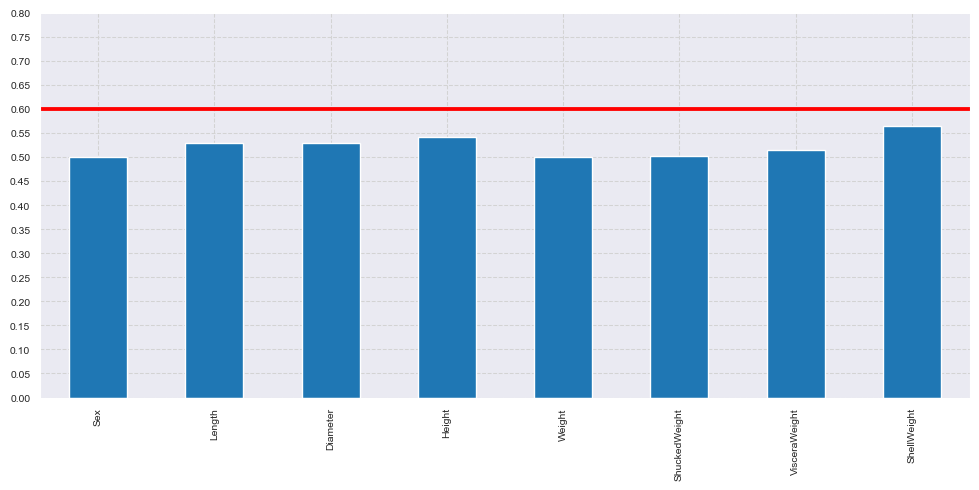


---------- Adversarial CV - Train vs Test ----------

---> Current feature = Sex
---> Current feature = Length
---> Current feature = Diameter
---> Current feature = Height
---> Current feature = Weight
---> Current feature = ShuckedWeight
---> Current feature = VisceraWeight
---> Current feature = ShellWeight

Results

{    'Diameter': 0.4979,
     'Height': 0.5008,
     'Length': 0.4982,
     'Sex': 0.5008,
     'ShellWeight': 0.5004,
     'ShuckedWeight': 0.4937,
     'VisceraWeight': 0.4994,
     'Weight': 0.4962}


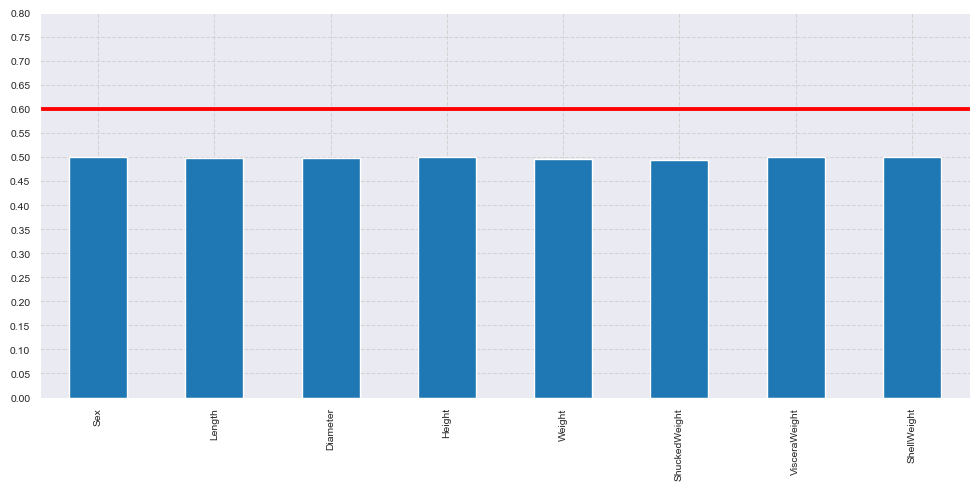


---------- Adversarial CV - Original vs Test ----------

---> Current feature = Sex
---> Current feature = Length
---> Current feature = Diameter
---> Current feature = Height
---> Current feature = Weight
---> Current feature = ShuckedWeight
---> Current feature = VisceraWeight
---> Current feature = ShellWeight

Results

{    'Diameter': 0.4986,
     'Height': 0.5013,
     'Length': 0.497,
     'Sex': 0.5008,
     'ShellWeight': 0.4993,
     'ShuckedWeight': 0.4951,
     'VisceraWeight': 0.5008,
     'Weight': 0.4966}


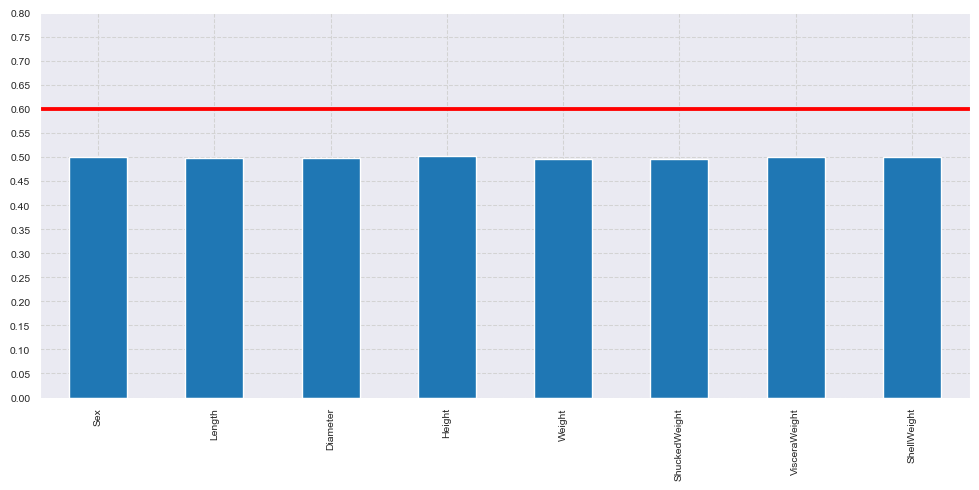


CPU times: total: 9min 37s
Wall time: 1min 26s


In [5]:
%%time

# Performing adversarial CV between the 2 specified datasets:-
def Do_AdvCV(df1:pd.DataFrame, df2:pd.DataFrame, source1:str, source2:str):
    "This function performs an adversarial CV between the 2 provided datasets if needed by the user";
    
    # Adversarial CV per column:-
    ftre = train.drop(columns = ['id', CFG.target, "Source"], errors = 'ignore').columns;
    adv_cv = {};

    for col in ftre:
        PrintColor(f"---> Current feature = {col}", style = Style.NORMAL);
        shuffle_state = np.random.randint(low = 10, high = 100, size= 1);

        full_df = \
        pd.concat([df1[[col]].assign(Source = source1), df2[[col]].assign(Source = source2)], 
                  axis=0, ignore_index = True).\
        sample(frac = 1.00, random_state = shuffle_state);

        full_df = full_df.assign(Source_Nb = full_df['Source'].eq(source2).astype(np.int8));

        # Checking for adversarial CV:-
        model = LGBMClassifier(random_state = CFG.state, max_depth = 6, learning_rate = 0.05);
        cv    = all_cv['SKF'];
        score = np.mean(cross_val_score(model, 
                                        full_df[[col]], 
                                        full_df.Source_Nb, 
                                        scoring= 'roc_auc', 
                                        cv= cv)
                       );
        adv_cv.update({col: round(score, 4)});
        collect();
    
    del ftre;
    
    PrintColor(f"\nResults\n");
    pprint(adv_cv, indent = 5, width = 20, depth = 1);
    collect();
    
    fig, ax = plt.subplots(1,1,figsize = (12, 5));
    pd.Series(adv_cv).plot.bar(color = 'tab:blue', ax = ax);
    ax.axhline(y = 0.60, color = 'red', linewidth = 2.75);
    ax.grid(**CFG.grid_specs); 
    plt.yticks(np.arange(0.0, 0.81, 0.05));
    plt.show();
    
# Implementing the adversarial CV:-
if CFG.adv_cv_req == "Y":
    PrintColor(f"\n---------- Adversarial CV - Train vs Original ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = train, df2 = original, source1 = 'Train', source2 = 'Original');
    
    PrintColor(f"\n---------- Adversarial CV - Train vs Test ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = train, df2 = test, source1 = 'Train', source2 = 'Test');
    
    PrintColor(f"\n---------- Adversarial CV - Original vs Test ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = train, df2 = test, source1 = 'Original', source2 = 'Test');   
    
if CFG.adv_cv_req == "N":
    PrintColor(f"\nAdversarial CV is not needed\n", color = Fore.RED);
    
collect();
print();

# Inferences

1) Train-test belong to the same distribution, we can perhaps rely on the CV score
2) We need to further check the train-original distribution further, adversarial validation results indicate that we can use the original dataset

# Visuals and EDA

## Target Plot

Target plot ---: 0it [00:00, ?it/s]

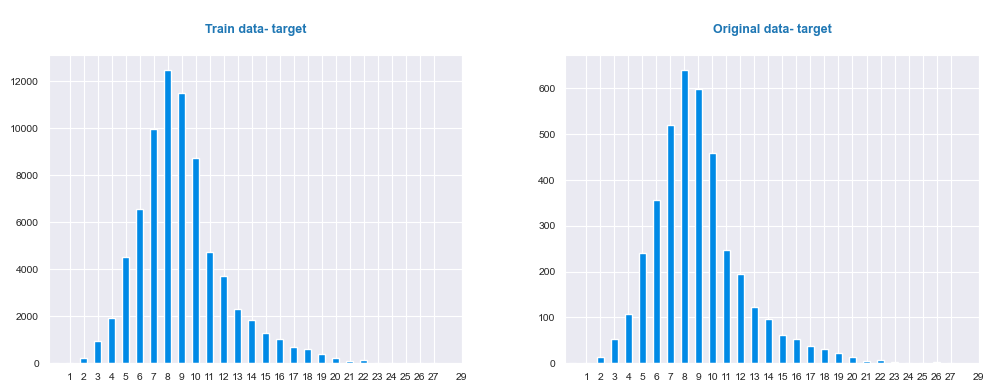


CPU times: total: 828 ms
Wall time: 767 ms


In [6]:
%%time

if CFG.ftre_plots_req == "Y":
    fig, axes = plt.subplots(1,2, figsize = (12, 4),gridspec_kw = {'wspace': 0.25});
    
    for i, df in tqdm(enumerate([train, original]), "Target plot ---"):
        ax = axes[i];
        _ = pd.Series(Counter(df[CFG.target]));
        _.sort_index(ascending = True).plot.bar(color = '#008ae6', ax = ax);
        df_name = 'Train' if i == 0 else "Original";
        ax.set_title(f"\n{df_name} data- target\n", **CFG.title_specs);
        ax.set_xticks(ticks = _.sort_index(ascending = True).index, 
                      labels = _.sort_index(ascending = True).index,
                      rotation = 0, fontsize = 7.5);

    plt.tight_layout();
    plt.show();
    
collect();
print();

# Pairplots


Train data- pair plots


CPU times: total: 17.5 s
Wall time: 17.4 s


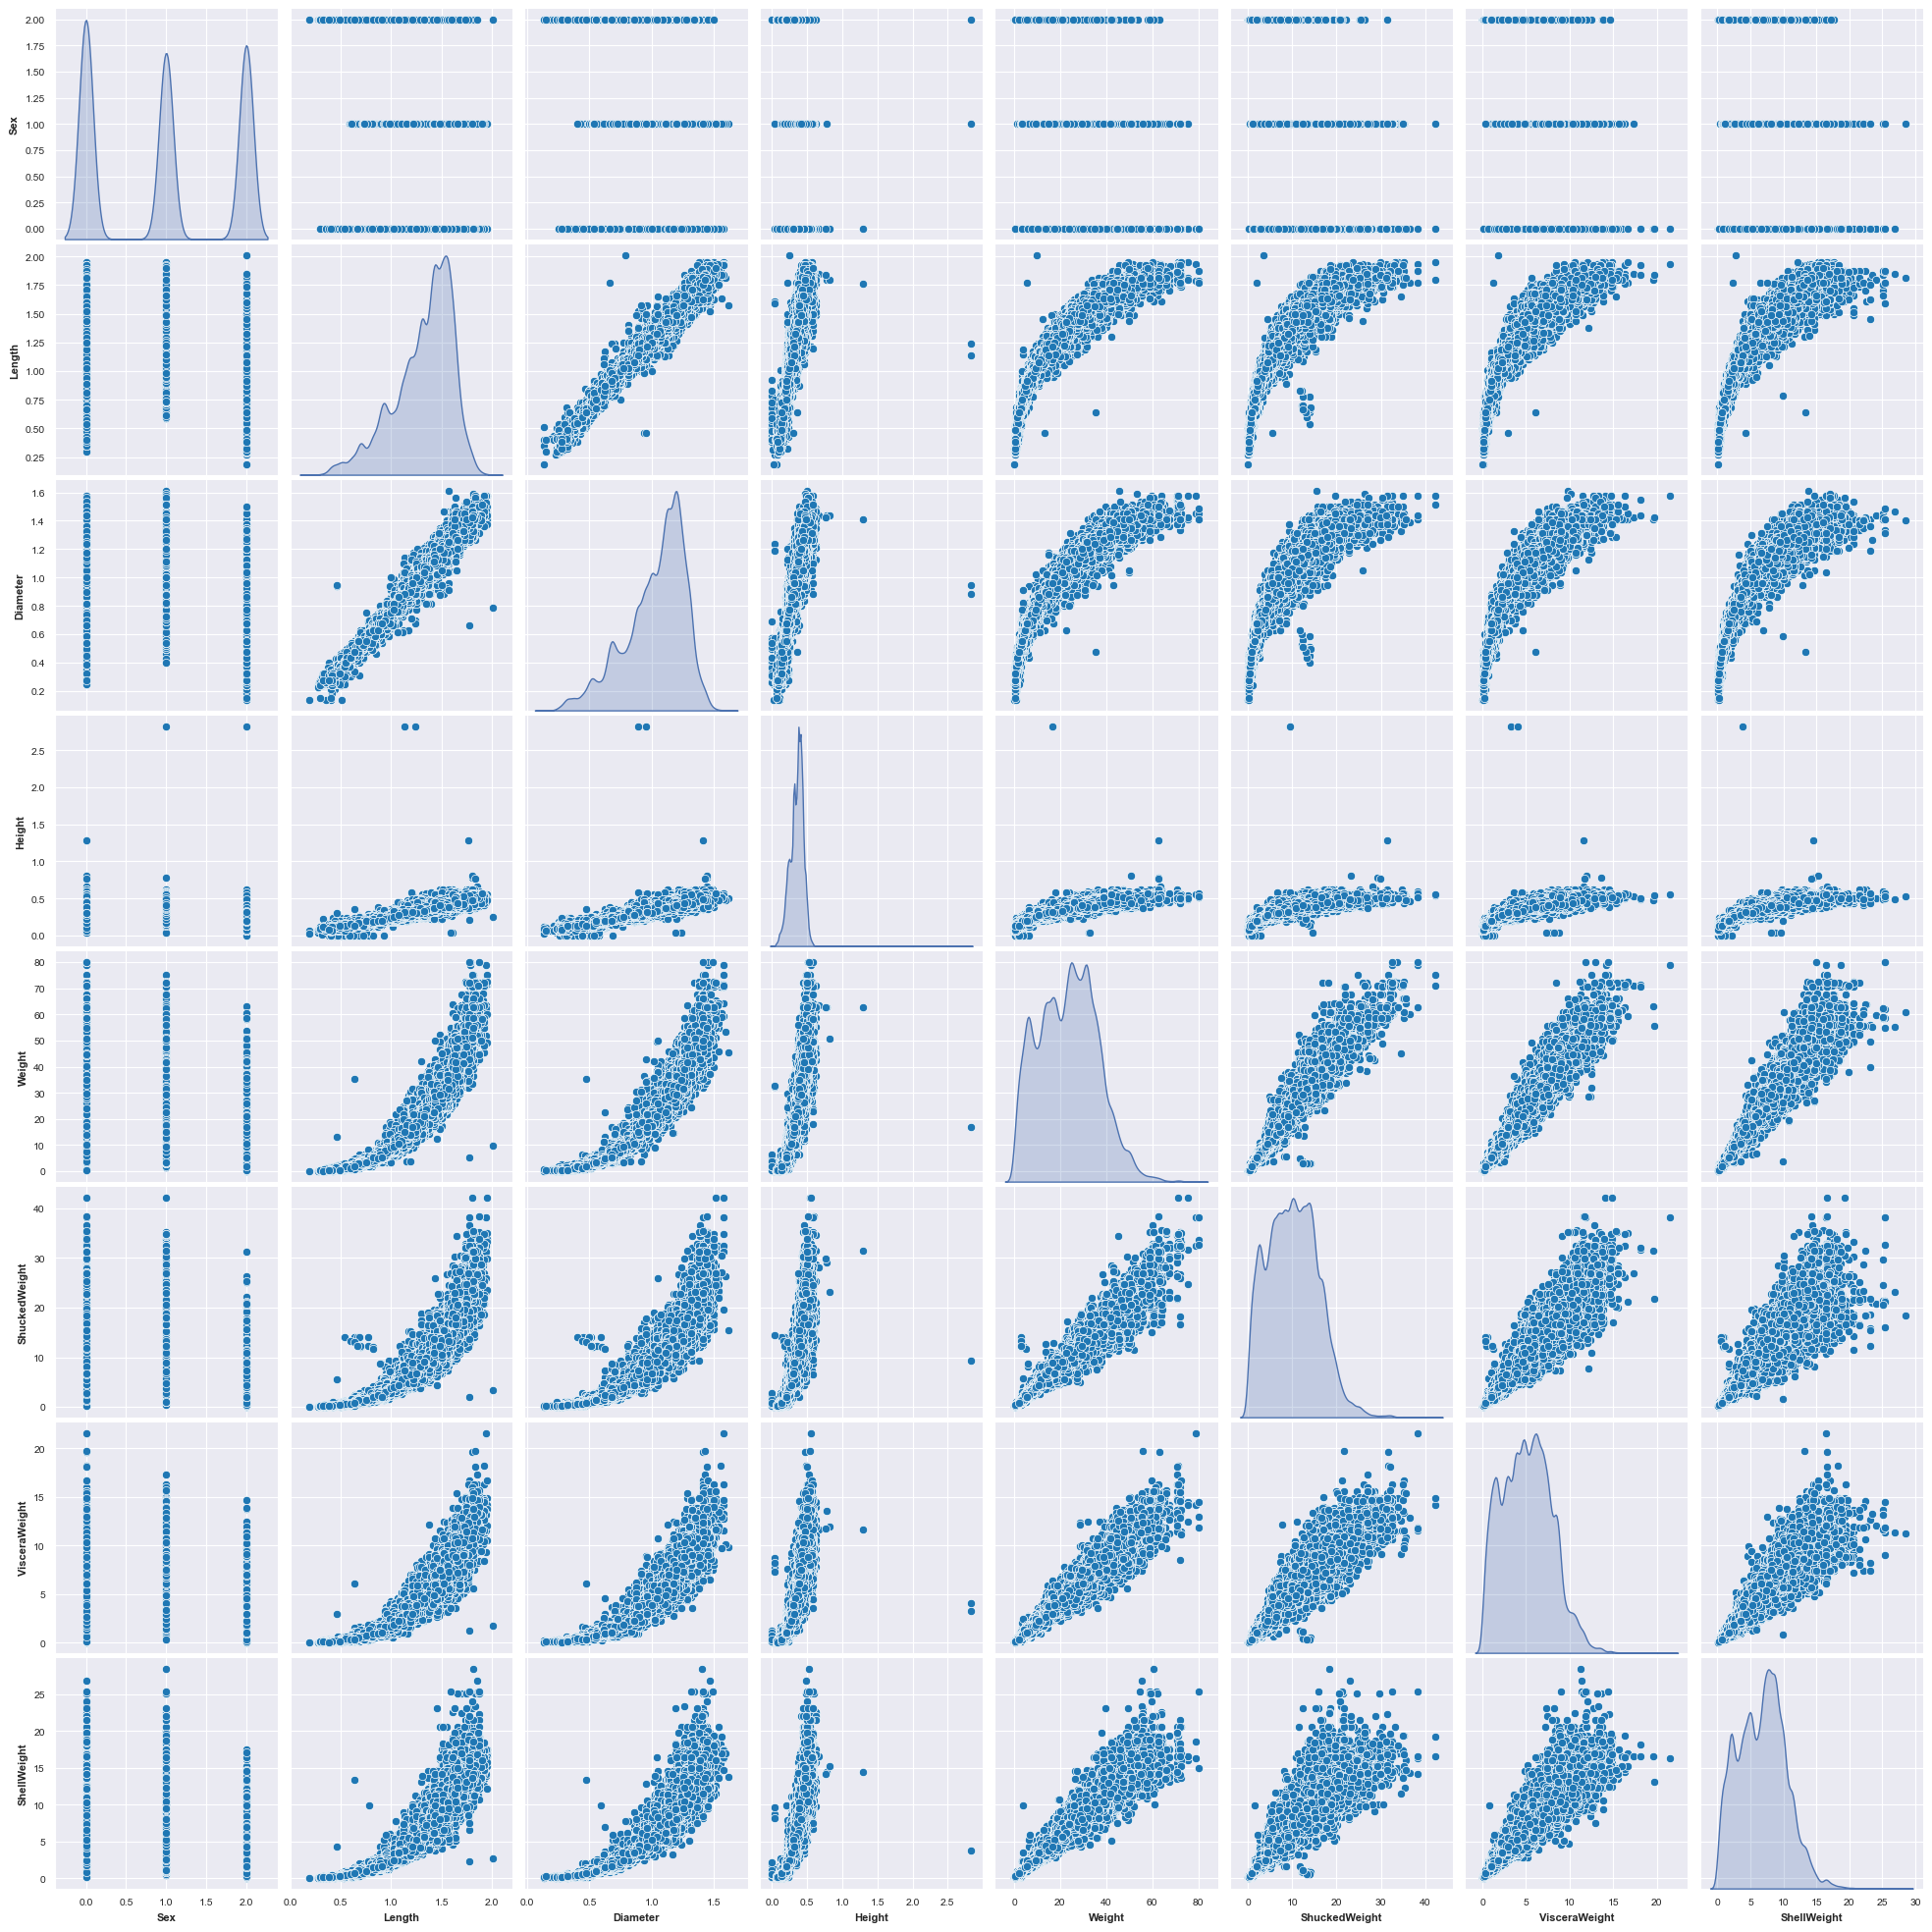

In [7]:
%%time 

if CFG.ftre_plots_req == "Y":
    PrintColor(f"\nTrain data- pair plots\n");
    _ = sns.pairplot(data = train.drop(columns = ['id','Source', CFG.target], errors = 'ignore'), 
                     diag_kind = 'kde', markers= 'o', plot_kws= {'color': 'tab:blue'}               
                    );

print();
collect();


Original data- pair plots


CPU times: total: 6.88 s
Wall time: 8.71 s


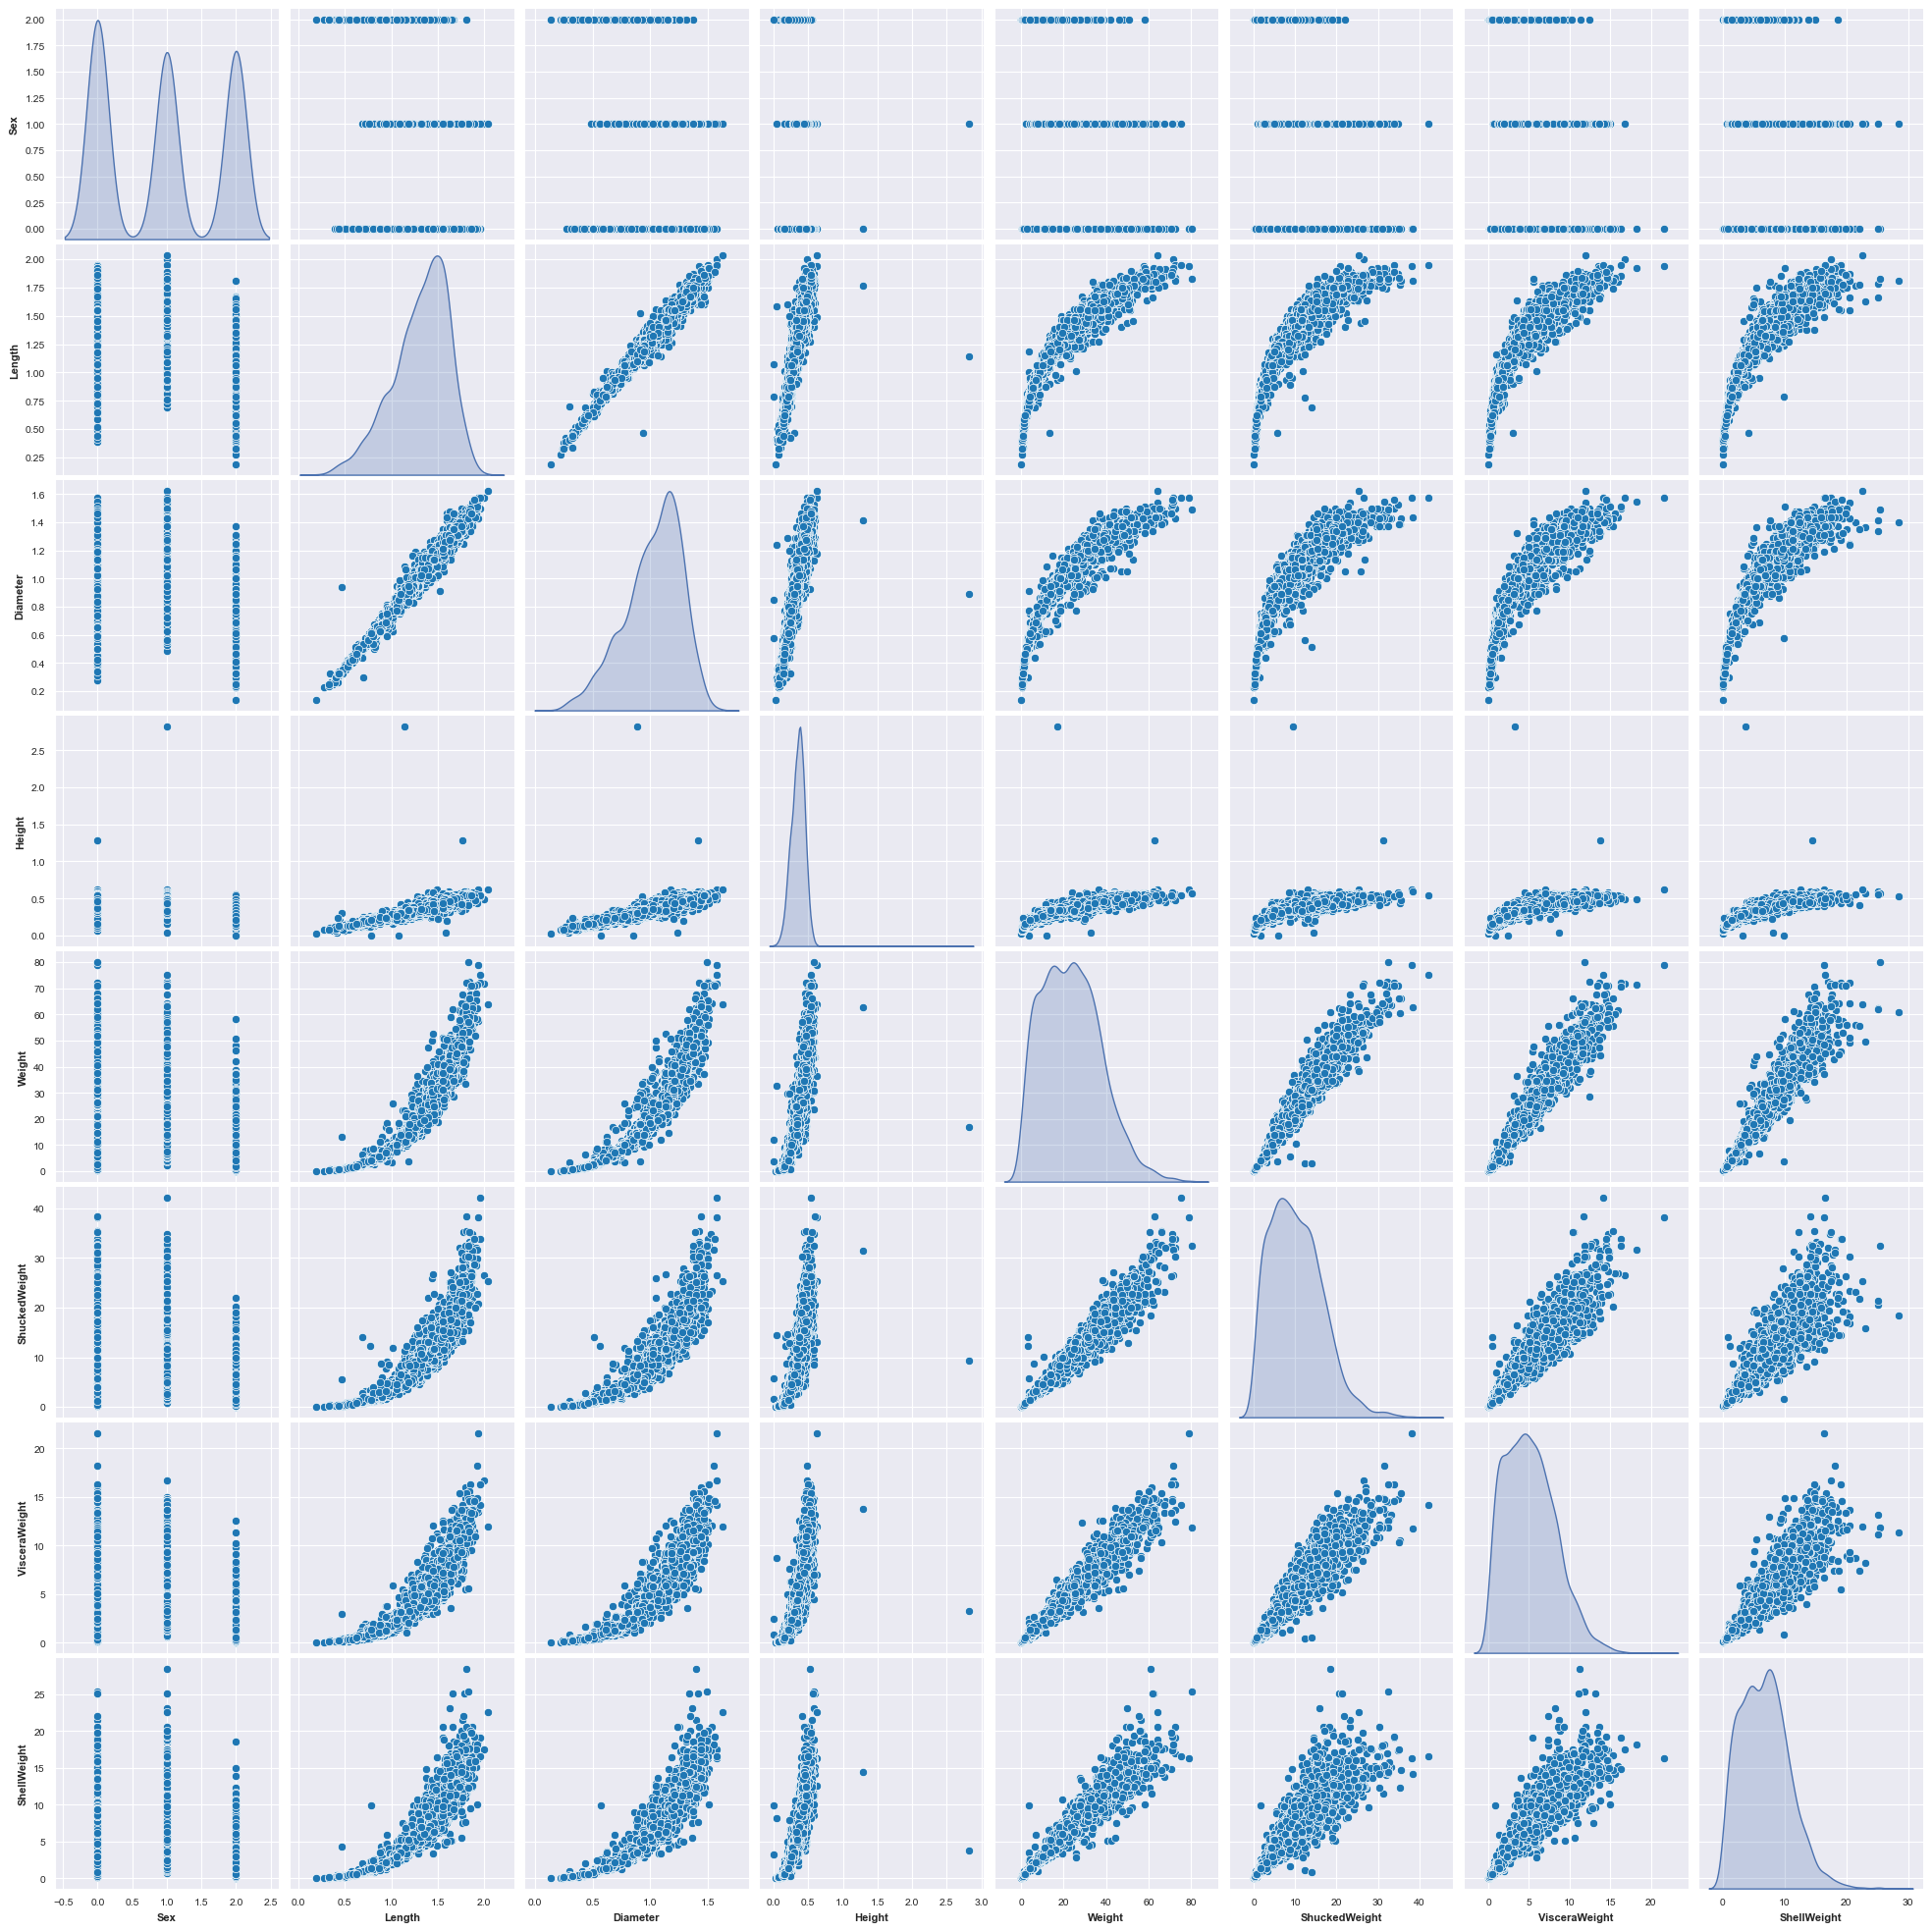

In [8]:
%%time 

if CFG.ftre_plots_req == "Y":
    PrintColor(f"\nOriginal data- pair plots\n");
    _ = sns.pairplot(data = original.drop(columns = ['id','Source', CFG.target], errors = 'ignore'), 
                     diag_kind = 'kde', markers= 'o', plot_kws= {'color': 'tab:blue'}               
                    );
print();
collect();

## Category Column Plots

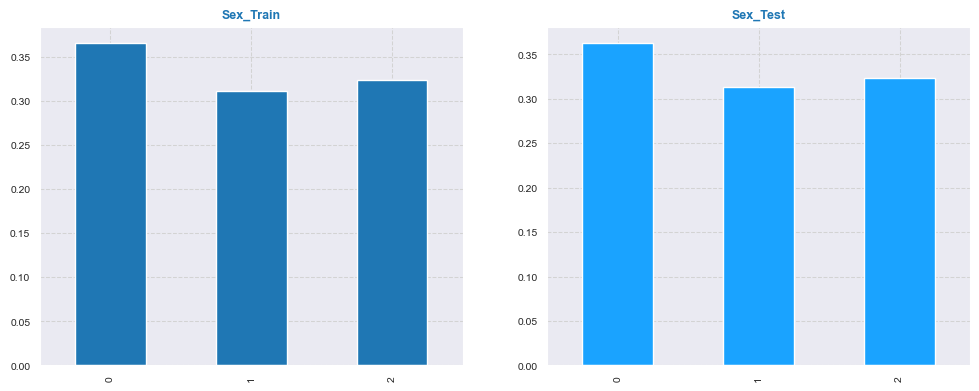


CPU times: total: 266 ms
Wall time: 426 ms


In [9]:
%%time

cat_cols = strt_ftre[0].split(' ')

if CFG.ftre_plots_req == "Y":
    fig, axes = plt.subplots(1, 2, figsize = (12, len(cat_cols)* 4.4), 
                             gridspec_kw = {'wspace': 0.2, 'hspace': 0.5});

    for i, col in enumerate(cat_cols):
        ax = axes[0];
        train[col].value_counts(normalize = True).sort_index().plot.bar(color = 'tab:blue', ax = ax);
        ax.set_title(f"{col}_Train", **CFG.title_specs);
        ax.grid(**CFG.grid_specs);
        ax.set(xlabel = '', ylabel = '');

        ax = axes[1];
        test[col].value_counts(normalize = True).sort_index().plot.bar(color = '#1aa3ff', ax = ax);
        ax.set_title(f"{col}_Test", **CFG.title_specs);
        ax.grid(**CFG.grid_specs);  
        ax.set(xlabel = '', ylabel = ''); 

    plt.tight_layout();
    plt.show();
    
print();
collect();

# Continous Column Plots

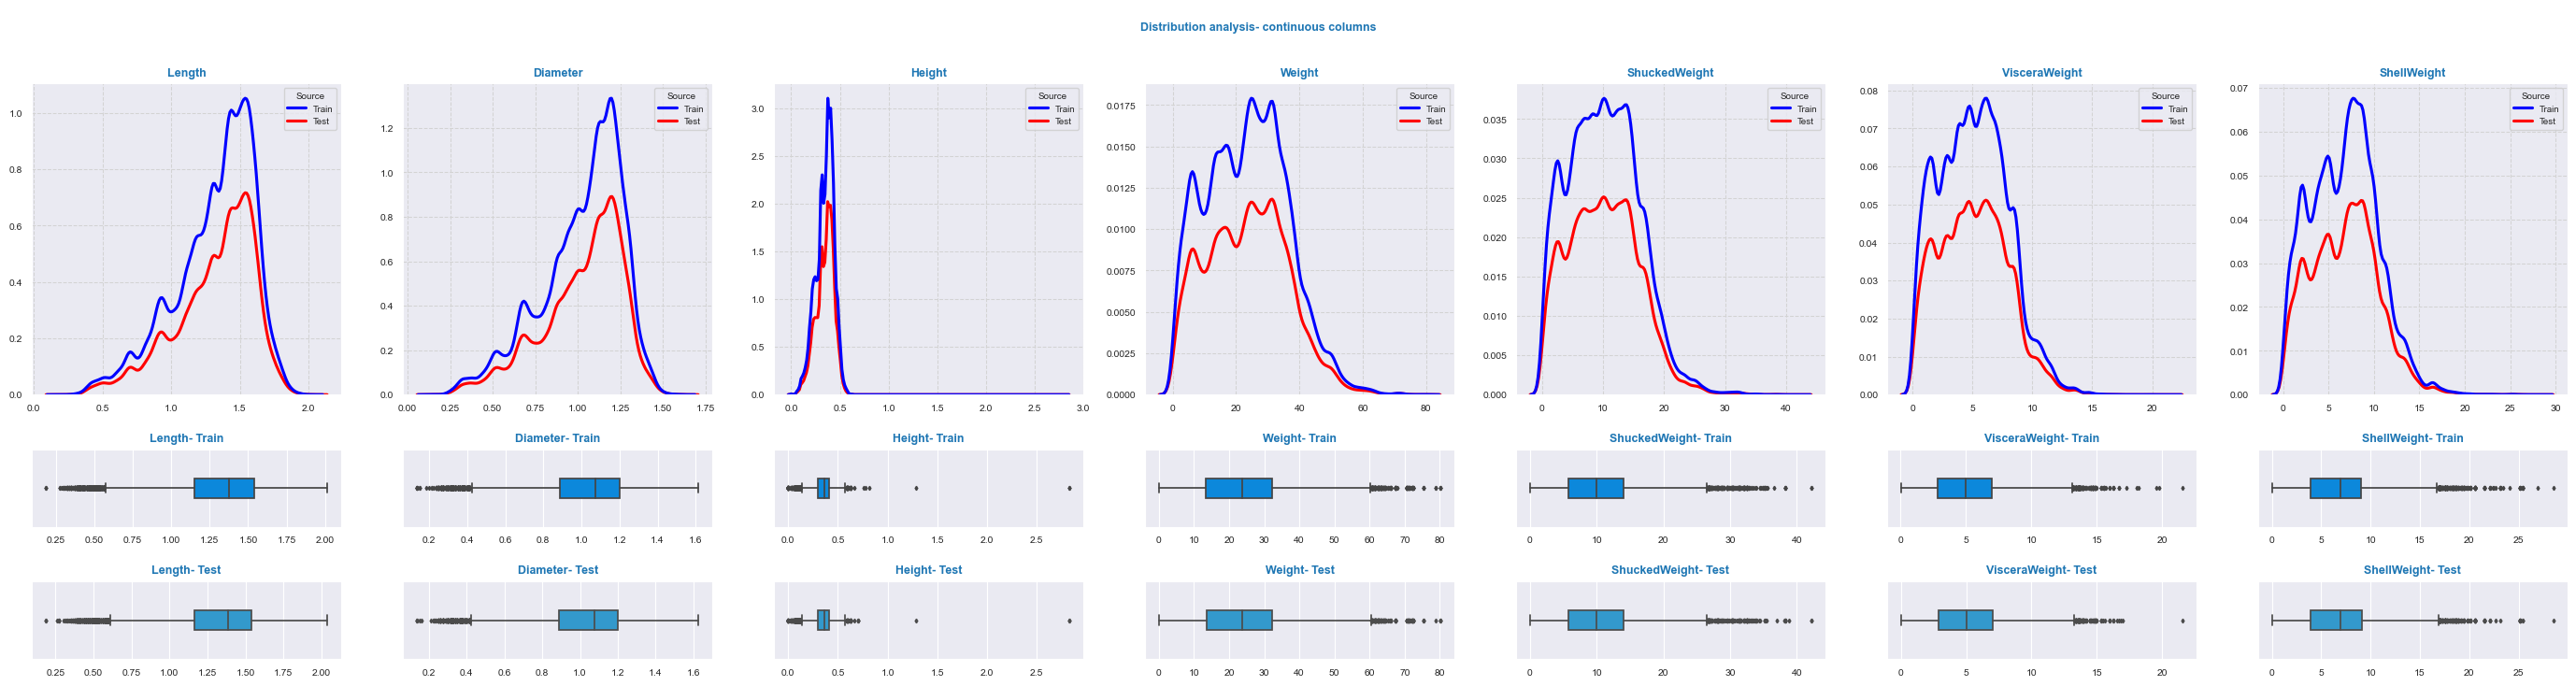


CPU times: total: 10.3 s
Wall time: 17.5 s


In [10]:
%%time 

cont_cols = strt_ftre[1:-1];

if CFG.ftre_plots_req == "Y":
    df = pd.concat([train[cont_cols].assign(Source = 'Train'), 
                    test[cont_cols].assign(Source = 'Test')], 
                   axis=0, ignore_index = True
                  );
    
    fig, axes = plt.subplots(3,len(cont_cols), figsize = (35, 8), 
                             gridspec_kw = {'hspace': 0.35, 'wspace': 0.2, 'height_ratios': [0.80, 0.20, 0.20]});
    
    for i,col in enumerate(cont_cols):
        ax = axes[0,i];
        sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', palette = ['blue', 'red'], 
                    ax = ax, linewidth = 2.25
                   );
        ax.set_title(f"\n{col}", **CFG.title_specs);
        ax.grid(**CFG.grid_specs);
        ax.set(xlabel = '', ylabel = '');
        
        ax = axes[1,i];
        sns.boxplot(data = df.loc[df.Source == 'Train', [col]], x = col, width = 0.25,
                    color = '#008ae6', saturation = 0.90, linewidth = 1.25, fliersize= 2.25,
                    ax = ax);
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"{col}- Train", **CFG.title_specs);
        
        ax = axes[2,i];
        sns.boxplot(data = df.loc[df.Source == 'Test', [col]], x = col, width = 0.25, fliersize= 2.25,
                    color = '#00aaff', saturation = 0.6, linewidth = 1.25, 
                    ax = ax); 
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"{col}- Test", **CFG.title_specs);
              
    plt.suptitle(f"\nDistribution analysis- continuous columns\n", **CFG.title_specs);
    plt.tight_layout();
    plt.show();
    
print();
collect();

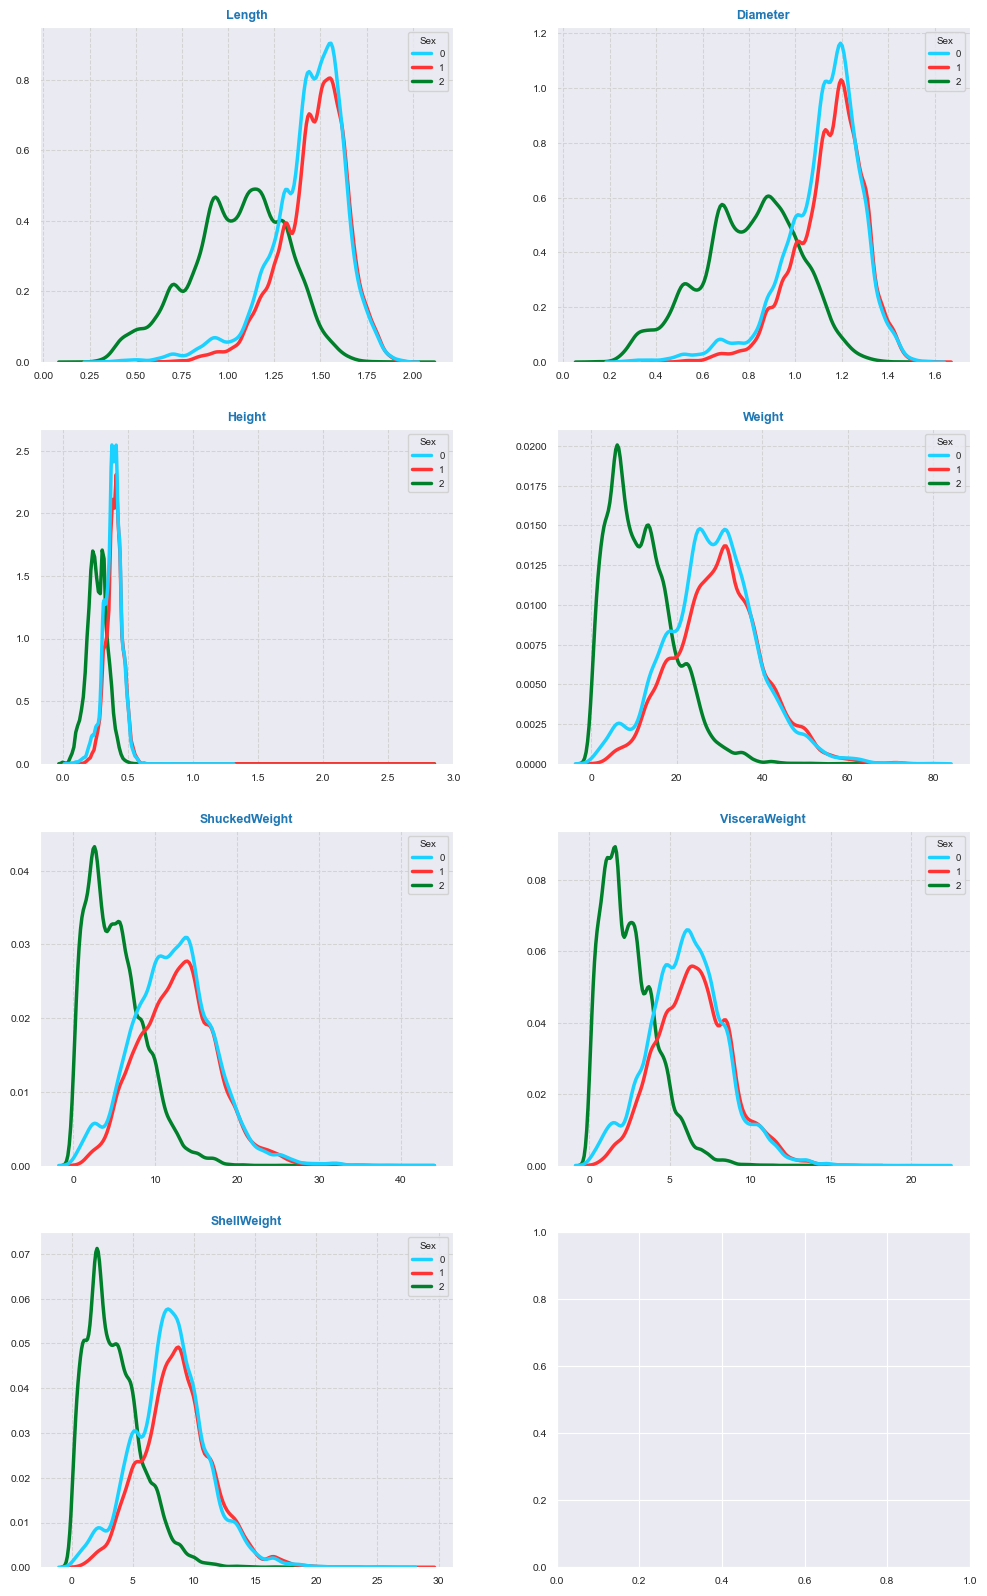


CPU times: total: 5.61 s
Wall time: 10.3 s


In [11]:
%%time 

if CFG.ftre_plots_req == "Y":
    fig, axes = plt.subplots(4,2, figsize = (12,20), gridspec_kw = {'hspace': 0.2, 'wspace': 0.25});  

    for i, col in enumerate(cont_cols):
        ax = axes[i//2, i%2];
        sns.kdeplot(data      = train, 
                    x         = col, 
                    hue       = cat_cols[0], 
                    palette   = ['#1ad1ff', '#ff3333', '#00802b'], 
                    ax        = ax, 
                    linewidth = 2.5,
                   );

        ax.set_title(col, **CFG.title_specs);
        ax.grid(**CFG.grid_specs);
        ax.set(xlabel = '', ylabel = '');

    plt.tight_layout();
    plt.show();
    
collect();
print();


# Duplicate Analysis

DUPLICATES ANALYSIS

We could simply place the training set predictions for the duplicate rows across all columns and complete the process

If we consider feature subsets, we could obtain higher number of duplicates. We may have to work with specific duplicate handling thereby

In [13]:
%%time

PrintColor(f"\n-------- Duplicates analysis --------\n", color = Fore.MAGENTA);

try: del _;
except Exception as e: pass;

_ = train.loc[train[strt_ftre[0:-1]].duplicated(keep = 'first')];
PrintColor(f"Train set duplicates = {len(_)} rows");

_ = test.loc[test[strt_ftre[0:-1]].duplicated(keep = 'first')];
PrintColor(f"Test set duplicates = {len(_)} rows");

_ = pd.concat([train[strt_ftre[0:-1]], test[strt_ftre[0:-1]]], axis= 0, ignore_index = False);
_ = len(_.loc[_.duplicated(keep = 'first')]);
PrintColor(f"Train-Test set combined duplicates = {_} rows");


dup_df = test.reset_index().merge(
    train.drop(columns=['Source'], errors='ignore').reset_index(),
    how='inner',
    on=list(strt_ftre[0:-1]),
    suffixes=('', '_train')
)[['id', 'id_train', CFG.target]]

PrintColor(f"\nDuplicated rows between train and test-\n")
display(dup_df.head(5).style.format(precision=2))


# dup_df = test.reset_index().merge(train.drop(columns = ['Source'], errors = 'ignore').reset_index(), 
#                                how     = 'inner', 
#                                on      = list(strt_ftre[0:-1]),
#                     suffixes = {'','_train'})[['id', 'id_train', CFG.target]];

# PrintColor(f"\nDuplicated rows between train and test-\n")
# display(dup_df.head(5).style.format(precision = 2))

print();
collect();


-------- Duplicates analysis --------

Train set duplicates = 0 rows
Test set duplicates = 0 rows
Train-Test set combined duplicates = 0 rows

Duplicated rows between train and test-



,id,id_train,Age



CPU times: total: 93.8 ms
Wall time: 231 ms


# Feature Interaction and Univariate Relations

FEATURE INTERACTION AND UNIVARIATE RELATIONS

We aim to do the below herewith

1) Correlation
2) Mutual information
3) Leave One Out model





CPU times: total: 125 ms
Wall time: 928 ms


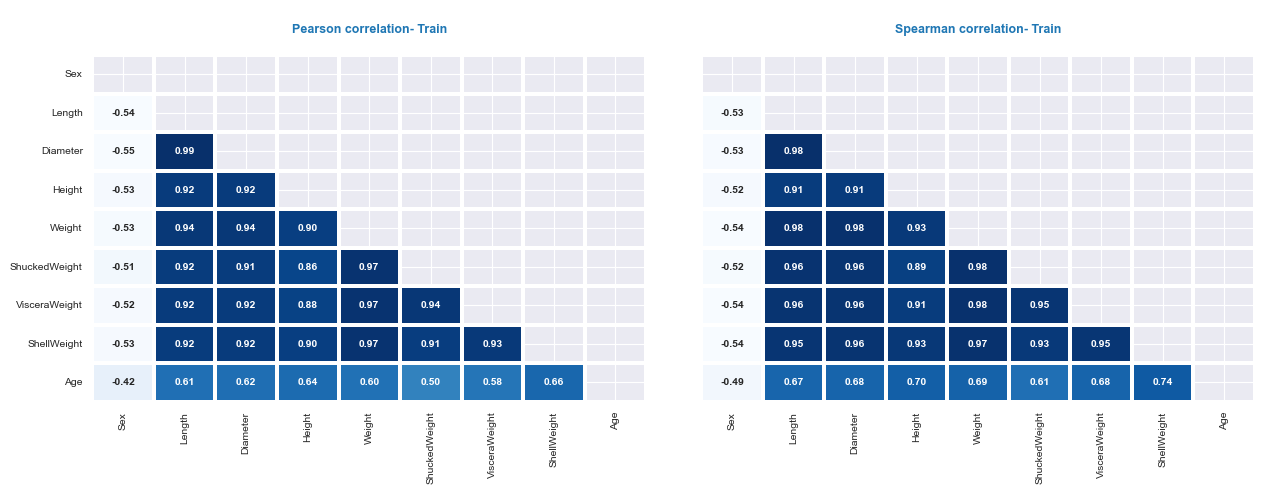

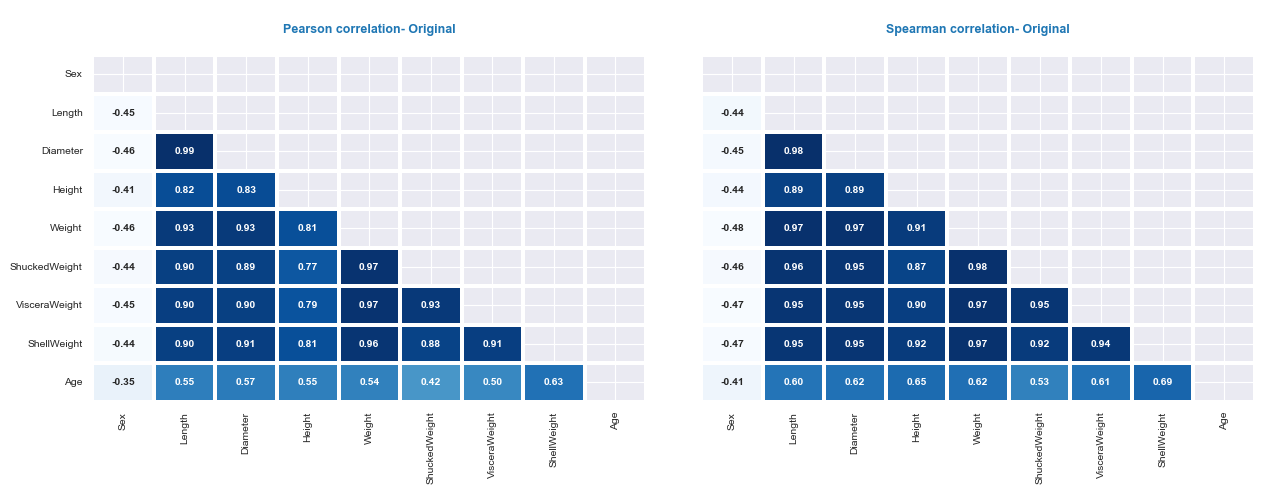

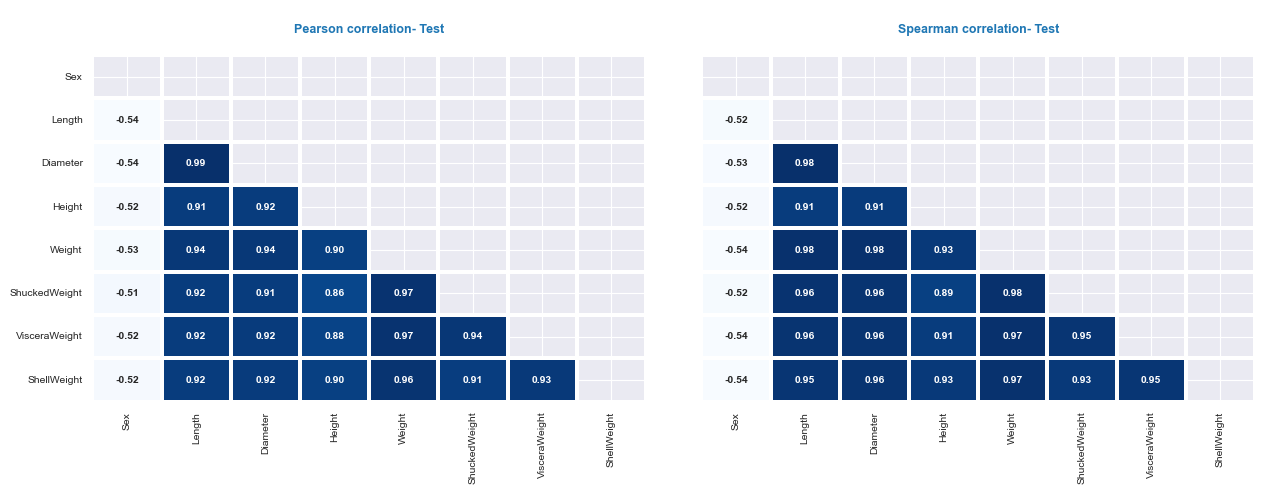

In [14]:
%%time 

def MakeCorrPlot(df: pd.DataFrame, data_label:str, figsize = (30, 9)):
    """
    This function develops the correlation plots for the given dataset
    """;
    
    fig, axes = plt.subplots(1,2, figsize = figsize, gridspec_kw = {'hspace': 0.2, 'wspace': 0.1},
                             sharey = True
                            );
    
    for i, method in enumerate(['pearson', 'spearman']):
        corr_ = df.drop(columns = ['id', 'Source'], errors = 'ignore').corr(method = method);
        ax = axes[i];
        sns.heatmap(data = corr_,  annot= True,fmt= '.2f', cmap = 'Blues',
                    annot_kws= {'fontweight': 'bold','fontsize': 7.5}, 
                    linewidths= 1.5, linecolor='white', cbar= False, mask= np.triu(np.ones_like(corr_)),
                    ax= ax
                   );
        ax.set_title(f"\n{method.capitalize()} correlation- {data_label}\n", **CFG.title_specs);
        
    collect();
    print();

# Implementing correlation analysis:-
MakeCorrPlot(df = train, data_label = 'Train', figsize = (15, 4.5));
MakeCorrPlot(df = original, data_label = 'Original', figsize = (15, 4.5));
MakeCorrPlot(df = test, data_label = 'Test', figsize = (15, 4.5));

print();
collect();

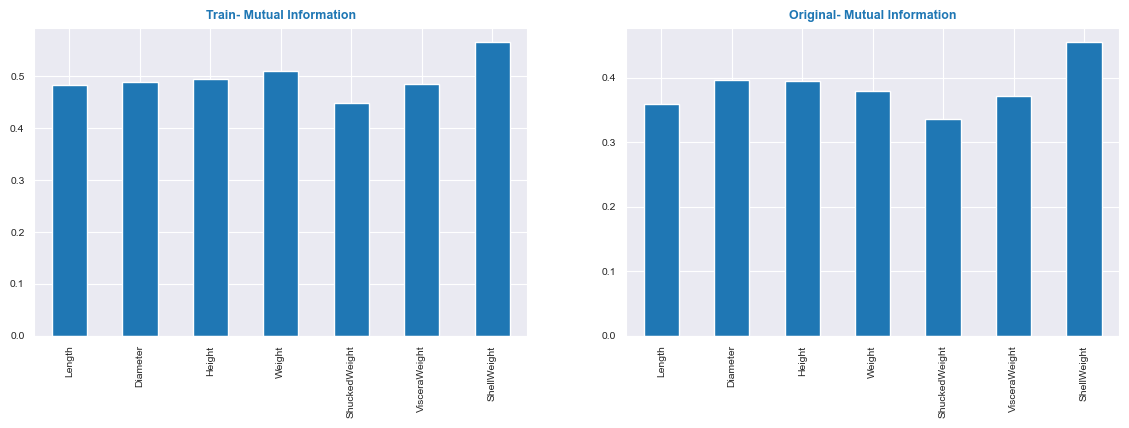


CPU times: total: 4.2 s
Wall time: 4.05 s


In [15]:
%%time 

MutInfoSum = {};
for i, df in enumerate([train, original]):
    MutInfoSum.update({'Train' if i == 0 else 'Original': 
                       mutual_info_regression(df[strt_ftre[1:-1]], df[CFG.target],random_state = CFG.state)
                      });

MutInfoSum = pd.DataFrame(MutInfoSum, index = strt_ftre[1:-1]);

fig, axes = plt.subplots(1,2, figsize = (14, 4), gridspec_kw = {'wspace': 0.2});
for i in range(2):
    MutInfoSum.iloc[:, i].plot.bar(ax = axes[i], color = 'tab:blue');
    axes[i].set_title(f"{MutInfoSum.columns[i]}- Mutual Information", **CFG.title_specs);

plt.tight_layout();
plt.show();
print();
collect();

In [16]:
%%time 
  
if CFG.ftre_imp_req == "Y":
    model = LGBMRegressor(max_depth     = 5, 
                          random_state  = CFG.state, 
                          num_leaves    = 120,
                          n_estimators  = 1800, 
                          objective     = 'mae', 
                          metric        = 'mean_absolute_error',
                          reg_alpha     = 0.000012,
                          reg_lambda    = 0.45,
                         );
    
    X = train.loc[train.Source == "Competition"].drop(columns = ['id', 'Source'], errors = 'ignore');
    X['noise'] = np.random.normal(0, 3.0, len(X));
    y,X = X[CFG.target], X.drop(columns = [CFG.target]);
  
    fig, ax = plt.subplots(1,1, figsize = (10, 4.5), gridspec_kw = {'hspace': 0.2});
    model.fit(X, y);
    PermFtreImp = \
    permutation_importance(model, X, y, 
                           scoring = 'neg_mean_absolute_error', 
                           n_repeats = 3,
                           random_state = CFG.state,
                          );
    PermFtreImp = pd.Series(np.mean(PermFtreImp['importances'], axis=1), index = X.columns);
    noise_level = PermFtreImp.loc['noise'];
    PermFtreImp.plot.bar(ax = ax, color = 'tab:blue');
    ax.axhline(y = noise_level, color = 'red', lw = 2.0, ls = '--');
    ax.set_title(f"Permutation Importance", **CFG.title_specs);
    plt.tight_layout();
    plt.show();
    del noise_level, X,y, PermFtreImp;

if CFG.ftre_imp_req != "Y":
    PrintColor(f"\nFeature importance is not required\n", color = Fore.RED);

collect();
print();


Feature importance is not required


CPU times: total: 125 ms
Wall time: 119 ms


# Inferences

1) All columns seem to be important and significant. Inter-column correlations seem to be important
2) We will pay special attention to Sex, length and weight. They seem to mirror the growth of the animal. Also gender based distributions are distinct across numerical columns
3) Original data could be included in the model. We will still test this with 2 versions and assess the CV score impact.
4) We have a few outliers in the continuous columns as seen in the box plot. We may have to treat them in a future run and then proceed with the CV score impact
5) All the columns are extremely highly correlated. It will be better to drop some of these columns for the model. Perhaps some dimensionality reduction methods will also work here
6) We cannot remove a set of features just because their permutation importances are lower than random noise. Permutation importance highlights the relative importance of a feature in a given model and seldom gives a complete picture of the predictability of the feature. We will try several feature combinations and check the CV score. That is the real indicator of model performance.

# Data Transforms

DATA TRANSFORMS

This section aims at creating secondary features, scaling and if necessary, conjoining the competition training and original data tables

In [17]:
%%time 

# Data transforms:-
class Xformer(TransformerMixin, BaseEstimator):
    """
    This class is used to create secondary features from the existing data
    """;
    
    def __init__(self): pass
    
    def fit(self, X, y= None, **params):
        self.ip_cols = X.columns;
        return self;
    
    def transform(self, X, y= None, **params):
        """
        This function does the below-
        1. Corrects the 0 height values with the nearest non-zero value. Height = 0 is meaningless.
        2. It creates secondary features if requested. Else it passes through.
        3. It 
        """;
        
        global strt_ftre;
        df    = X.copy();      
      
        if CFG.sec_ftre_req == "Y":
            df['PseudoBMI']      = (df['Weight'] / (df['Height']**2)).clip(0, 4000);
            df['LenDivDiam']     = df['Length'] / df['Diameter'];
            df['WgtDivVisWgt']   = np.clip(df['Weight'] / df['VisceraWeight'], 0, 1000);
            df['WgtDivShellWgt'] = np.clip(df['Weight'] / df['ShellWeight'],0,1000);
            df['WgtDivShckWgt']  = np.clip(df['Weight'] / df['ShuckedWeight'],0,1000);

        if CFG.sec_ftre_req != "Y": 
            PrintColor(f"Secondary features are not required", color = Fore.RED);
            
        self.op_cols = df.columns;  
        return df;
    
    def get_feature_names_in(self, X, y=None, **params): 
        return self.ip_cols;    
    
    def get_feature_names_out(self, X, y=None, **params): 
        return self.op_cols;
     
# Scaling:-
class Scaler(TransformerMixin, BaseEstimator):
    """
    This class aims to create scaling for the provided dataset
    """;
    
    def __init__(self, scl_method: str, scale_req: str):
        self.scl_method = scl_method;
        self.scale_req  = CFG.scale_req;
        
    def fit(self,X, y=None, **params):
        "This function calculates the train-set parameters for scaling";
        
        self.scl_cols        = X.drop(columns = ['id', 'Source', CFG.target], errors = 'ignore').columns;
        self.params          = X[self.scl_cols].describe(percentiles = [0.25, 0.50, 0.75]).drop(['count'], axis=0).T;
        self.params['iqr']   = self.params['75%'] - self.params['25%'];
        self.params['range'] = self.params['max'] - self.params['min'];
        
        return self;
    
    def transform(self,X, y=None, **params):  
        "This function transform the relevant scaling columns";
        
        df = X.copy();
        if self.scale_req == "Y":
            if CFG.scl_method == "Z":
                df[self.scl_cols] = (df[self.scl_cols].values - self.params['mean'].values) / self.params['std'].values;
            elif CFG.scl_method == "Robust":
                df[self.scl_cols] = (df[self.scl_cols].values - self.params['50%'].values) / self.params['iqr'].values;
            elif CFG.scl_method == "MinMax":
                df[self.scl_cols] = (df[self.scl_cols].values - self.params['min'].values) / self.params['range'].values;
        else:
            PrintColor(f"Scaling is not needed", color = Fore.RED);
    
        return df;
    
collect();
print();


CPU times: total: 109 ms
Wall time: 112 ms


In [18]:
%%time 

PrintColor(f"\n{'-'* 20} Data transforms, encoding and scaling {'-'* 20}", 
           color = Fore.MAGENTA);
PrintColor(f"\nTrain data shape before transforms = {train.shape}");

# Conjoining the train and original data:-
if CFG.conjoin_orig_data == "Y":
    train = pd.concat([train, original], axis=0, ignore_index = True);
    PrintColor(f"We are using the training and original data", color = Fore.RED);
    
# Adjusting the data for duplicates:-
if CFG.conjoin_orig_data == "N":
    PrintColor(f"We are using the training data only", color = Fore.RED);
    
PrintColor(f"Train data shape after conjoining = {train.shape}\n");
display(train.columns);

PrintColor(f"\nTrain data shape before de-dup = {train.shape}");
_     = list(train.drop(columns = ['id', CFG.target], errors = 'ignore').columns);
train = train.groupby(_).agg({CFG.target : np.mean}).reset_index();
PrintColor(f"Train data shape after de-dup = {train.shape}");
del _;

# Part 1:- Data transforms:--
pipe = Pipeline(steps = [('Xform', Xformer()), 
                         ('Scl',Scaler(scl_method = CFG.scl_method, scale_req = CFG.scale_req))
                        ]);
pipe.fit(train.drop(columns = [CFG.target]), train[CFG.target]);
train, Xtest = pipe.transform(train), pipe.transform(test);
PrintColor(f"Train-test data shape after scaling = {train.shape} {Xtest.shape}");

# Part 2:- Creating Xtrain and ytrain:--
Xtrain, ytrain = train.drop([CFG.target], axis=1), train[CFG.target];
PrintColor(f"Train-test data shape after all transforms = {Xtrain.shape} {Xtest.shape}");

print();
collect();



-------------------- Data transforms, encoding and scaling --------------------

Train data shape before transforms = (74051, 10)
We are using the training and original data
Train data shape after conjoining = (77944, 10)



Index(['Sex', 'Length', 'Diameter', 'Height', 'Weight', 'ShuckedWeight',
       'VisceraWeight', 'ShellWeight', 'Age', 'Source'],
      dtype='object')


Train data shape before de-dup = (77944, 10)
Train data shape after de-dup = (77944, 10)
Scaling is not needed
Scaling is not needed
Train-test data shape after scaling = (77944, 15) (49368, 14)
Train-test data shape after all transforms = (77944, 14) (49368, 14)

CPU times: total: 62.5 ms
Wall time: 206 ms


# Feature Analysis after Transforms

We aim to do the below herewith-

Correlation

Mutual Information

Comparison of all features with random noise

Source idea for point 3 - https://www.kaggle.com/competitions/playground-series-s3e14/discussion/406873

In [19]:
%%time

if CFG.ftre_imp_req == "Y":
    PrintColor(f"\n{'-'* 30} Feature analysis after data transforms {'-'* 30}\n");

    # Correlation:-
    MakeCorrPlot(df = Xtrain, data_label = "Train", figsize = (32, 9));
    MakeCorrPlot(df = Xtest, data_label = "Test", figsize = (32, 9));

    # Making univariate specific interim tables:-
    X = Xtrain.loc[Xtrain.Source == 'Competition'].drop(columns = ['Source', 'id'], errors = 'ignore');
    X['noise'] = np.random.normal(0.0, 3.0, len(X));
    y = ytrain.loc[X.index];
    Unv_Snp = pd.DataFrame(index = X.columns,columns = ['MutInfo']);

    # Mutual information:-
    Unv_Snp['MutInfo'] = mutual_info_regression(X,y,random_state = CFG.state);

    fig, axes = plt.subplots(1,2, figsize = (20, 4.5), 
                             gridspec_kw = {'wspace': 0.2, 'hspace': 0.25});
    ax = axes[0];
    Unv_Snp['MutInfo'].plot.bar(ax = ax, color = 'tab:blue');
    ax.set_title(f"Mutual Information", **CFG.title_specs);

    # Permutation Importance:-
    model = LGBMRegressor(max_depth     = 6, 
                          random_state  = CFG.state, 
                          num_leaves    = 120,
                          n_estimators  = 5_000, 
                          objective     = 'mae', 
                          metric        = 'mean_absolute_error',
                          reg_alpha     = 0.001,
                          reg_lambda    = 0.35,
                         );

    model.fit(X, y);
    PermFtreImp = \
    permutation_importance(model, X, y, 
                           scoring = 'neg_mean_absolute_error', 
                           n_repeats = 3,
                           random_state = CFG.state,
                          );
    Unv_Snp = \
    pd.concat([Unv_Snp, 
               pd.Series(np.mean(PermFtreImp['importances'], axis=1), index = X.columns)],
              axis=1).rename(columns = {0: 'PermFtreImp'});

    ax = axes[1];
    Unv_Snp['PermFtreImp'].plot.bar(ax = ax, color = 'tab:blue');
    ax.set_title(f"Permutation Importance", **CFG.title_specs);

    plt.tight_layout();
    plt.show();

    PrintColor(f"\nUnivariate Snapshot\n");
    display(Unv_Snp.\
            sort_values(by = ['PermFtreImp'], ascending = False).\
            style.\
            format(precision = 3)
           );

    del X,y;
    
else:
    PrintColor(f"\nFeature importance is not needed\n", color = Fore.RED);
    
print();
collect();


Feature importance is not needed


CPU times: total: 109 ms
Wall time: 112 ms


# Model Training

We commence our model assignment with a simple ensemble of tree-based and linear models and then shall proceed with the next steps

Pseudo Huber error for XGBoost is taken from https://www.kaggle.com/code/oscarm524/ps-s3-ep16-eda-modeling-submission

In [20]:
%%time 

def PostProcessPred(preds, post_process = "N"):
    """
    This function is inspired by the discussion link above-
    We round off the predicted values (OOF and test) to the nearest value of the unique target value
    As we do not have value 28 in the data, we assume any value from 27.5 onwards = 29
    """;
    if post_process == "Y":
        return np.select([preds > 27.5], [29], np.round(preds, decimals = 0));
    else:
        return preds;

print();
collect();


CPU times: total: 109 ms
Wall time: 103 ms


In [21]:
%%time 

# Initializing model I-O:-

Mdl_Master = \
{'CBR': CatBoostRegressor(**{'task_type'           : "GPU" if CFG.gpu_switch == "ON" else "CPU",
                             'loss_function'       : 'MAE',
                             'eval_metric'         : 'MAE',
                             'bagging_temperature' : 2.5,
                             'colsample_bylevel'   : 0.75,
                             'iterations'          : 12_000,
                             'learning_rate'       : 0.067,
                             'od_wait'             : 40,
                             'max_depth'           : 6,
                             'l2_leaf_reg'         : 1.575,
                             'min_data_in_leaf'    : 28,
                             'random_strength'     : 0.55, 
                             'max_bin'             : 256,
                           }
                        ),

 'LGBMR': LGBMRegressor(**{'device'            : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'         : 'regression_l1',
                           'metric'            : 'mean_absolute_error',
                           'boosting_type'     : 'gbdt',
                           'random_state'      : CFG.state,
                           'feature_fraction'  : 0.70,
                           'learning_rate'     : 0.018,
                           'max_depth'         : 8,
                           'n_estimators'      : 12_000,
                           'num_leaves'        : 80,                    
                           'reg_alpha'         : 1.25,
                           'reg_lambda'        : 3.5,
                           'verbose'           : -1,
                         }
                      ),

 'XGBR': XGBRegressor(**{'objective'          : 'reg:pseudohubererror',
                         'eval_metric'        : 'mae',
                         'random_state'       : CFG.state,
                         'tree_method'        : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                         'colsample_bytree'   : 0.75,
                         'learning_rate'      : 0.015,
                         'max_depth'          : 7,
                         'n_estimators'       : 5000,                         
                         'reg_alpha'          : 1.25,
                         'reg_lambda'         : 1e-05,
                         'min_child_weight'   : 40,
                        }
                     ),
 
 'GBR' : GBR(**{'loss'            : 'squared_error',
                'learning_rate'   : 0.065,
                'n_estimators'    : 650,
                'min_samples_leaf': 28,
                'max_depth'       : 9,
                'random_state'    : CFG.state,
                'alpha'           : 0.65,
                'n_iter_no_change': 180,
                'tol'             : 0.0001, 
              }
           ),
 
 'HGBR': HGBR(**{'loss'              : 'absolute_error',
                 'l2_regularization' : 0.825,
                 'learning_rate'     : 0.065,
                 'max_depth'         : 8,
                 'min_samples_leaf'  : 36,
                 'n_iter_no_change'  : 220,
                 'tol'               : 1e-04,
                 'verbose'           : 0,
                 'random_state'      : CFG.state,
                }
             )
};

# Selecting relevant columns for the train and test sets:-
sel_cols = ['Source',
            'Sex', 'Length', 'Diameter', 'Height', 'Weight', 'ShuckedWeight',
            'VisceraWeight', 'ShellWeight', 
            'PseudoBMI' 
           ];
try: 
    Xtrain, Xtest = Xtrain[sel_cols], Xtest[sel_cols];
except: 
    PrintColor(f"\n---> Check the columns selected\n---> Selected columns-", color = Fore.RED);
    pprint(Xtest.columns, depth = 1, width = 10, indent = 5);

# Initializing output tables for the models:-
methods   = list(Mdl_Master.keys());
OOF_Preds = pd.DataFrame(columns = methods);
Mdl_Preds = pd.DataFrame(index = sub_fl['id'], columns = methods);
FtreImp   = pd.DataFrame(index = Xtrain.drop(columns = [CFG.target, 'Source', 'Label'],
                                             errors = 'ignore').columns, 
                         columns = methods
                        );
Scores    = pd.DataFrame(columns = methods);

PrintColor(f"\n---> Selected model options- ");
pprint(methods, depth = 1, width = 100, indent = 5);

print();
collect();



---> Selected model options- 
['CBR', 'LGBMR', 'XGBR', 'GBR', 'HGBR']

CPU times: total: 125 ms
Wall time: 124 ms


In [22]:
%%time 

def TrainMdl(method:str):
    
    global Mdl_Master, Mdl_Preds, OOF_Preds, all_cv, FtreImp, Xtrain, ytrain; 
    
    model     = Mdl_Master.get(method); 
    cols_drop = ['id', 'Source', 'Label'];
    scl_cols  = [col for col in Xtrain.columns if col not in cols_drop];
    cv        = all_cv.get(CFG.mdlcv_mthd);
    Xt        = Xtest.copy(deep = True);
    
    if CFG.scale_req == "N" and method.upper() in ['RIDGE', 'LASSO', 'SVR']:
        X, y        = Xtrain, ytrain;
        scaler      = all_scalers['Z'];
        X[scl_cols] = scaler.fit_transform(X[scl_cols]);
        Xt[scl_cols]= scaler.transform(Xt[scl_cols]);
        PrintColor(f"--> Scaling the data for {method} model");

    if CFG.use_orig_allfolds == "Y":
        X    = Xtrain.query("Source == 'Competition'");
        y    = ytrain.loc[ytrain.index.isin(X.index)]; 
        Orig = pd.concat([Xtrain, ytrain], axis=1).query("Source == 'Original'");
        
    elif CFG.use_orig_allfolds != "Y":
        X,y = Xtrain.copy(deep = True), ytrain.copy(deep = True);
                
    # Initializing I-O for the given seed:-        
    test_preds = 0;
    oof_preds  = pd.DataFrame(); 
    scores     = [];
    ftreimp    = 0;
          
    for fold_nb, (train_idx, dev_idx) in enumerate(cv.split(X, y)): 
        Xtr  = X.iloc[train_idx].drop(columns = cols_drop, errors = 'ignore');   
        Xdev = X.iloc[dev_idx].loc[X.Source == "Competition"].\
        drop(columns = cols_drop, errors = 'ignore'); 
        ytr  = y.loc[y.index.isin(Xtr.index)];
        ydev = y.loc[y.index.isin(Xdev.index)];

        if CFG.use_orig_allfolds == "Y":
            Xtr = pd.concat([Xtr, Orig.drop(columns = [CFG.target, 'Source'], errors = 'ignore')], 
                            axis = 0, ignore_index = True);
            ytr = pd.concat([ytr, Orig[CFG.target]], axis = 0, ignore_index = True);
            
        # Fitting the model:- 
        try:     
            model.fit(Xtr, ytr, 
                      eval_set = [(Xdev, ydev)], 
                      verbose = 0,
                      early_stopping_rounds = CFG.nbrnd_erly_stp
                     ); 
        except: 
            model.fit(Xtr, ytr) 
            
        # Collecting predictions and scores and post-processing OOF:-
        dev_preds = PostProcessPred(model.predict(Xdev), post_process= CFG.pstprcs_train);
        score     = ScoreMetric(ydev, dev_preds);
        scores.append(score); 
 
        Scores.loc[fold_nb, method] = np.round(score, decimals= 6);
        oof_preds = pd.concat([oof_preds,
                               pd.DataFrame(index   = Xdev.index, 
                                            data    = dev_preds,
                                            columns = [method])
                              ],axis=0, ignore_index= False
                             );  
    
        oof_preds = pd.DataFrame(oof_preds.groupby(level = 0)[method].mean());
        oof_preds.columns = [method];
        
        test_preds = test_preds + model.predict(Xt.drop(columns = cols_drop, errors = 'ignore')); 
        
        try: 
            ftreimp += model.feature_importances_;
        except:
            ftreimp = 0;
            
    num_space = 10 - len(method);
    PrintColor(f"--> {method}{'-' * num_space} CV = {np.mean(scores):.6f}");
    del num_space;
    
    OOF_Preds[f'{method}'] = PostProcessPred(oof_preds.values.flatten(), CFG.pstprcs_train);
    
    if CFG.mdlcv_mthd in ['KF', 'SKF']:
        Mdl_Preds[f'{method}'] = test_preds.flatten()/ CFG.n_splits; 
        FtreImp[method]        = ftreimp / CFG.n_splits;
    else:
        Mdl_Preds[f'{method}'] = test_preds.flatten()/ (CFG.n_splits * CFG.n_repeats); 
        FtreImp[method]        = ftreimp / (CFG.n_splits * CFG.n_repeats);
    
    collect(); 
    
# Implementing the ML models:-
if CFG.ML == "Y": 
    PrintColor(f"\n{'-' * 25} ML model training {'-' * 25}\n", color = Fore.MAGENTA);
    for method in tqdm(methods, "ML models----"): 
        TrainMdl(method);
    clear_output();
    
    PrintColor(f"\nCV scores across methods\n");
    display(pd.concat([Scores.mean(axis = 0), Scores.std(axis = 0)], axis=1).\
            rename(columns = {0: 'Mean', 1: 'Std'}).\
            style.format(precision = 6).background_gradient(cmap = 'winter')
           );    
else:
    PrintColor(f"\nML models are not needed\n", color = Fore.RED);
    
collect();
print();


CV scores across methods



,Mean,Std
CBR,1.355835,0.010950
LGBMR,1.354326,0.011098
XGBR,1.366625,0.011153
GBR,1.405834,0.010540
HGBR,1.372034,0.011398



CPU times: total: 39min 8s
Wall time: 11min 3s


# Ensemble and Submission

In [23]:
%%time 

if CFG.ensemble_req == "Y":
    sub_fl['Ensemble'] = np.average(Mdl_Preds[methods], weights = [0.35, 0.35, 0.20, 0.02, 0.08], axis=1);
    sub_fl['Ensemble_PP'] = \
    PostProcessPred(sub_fl['Ensemble'].values, post_process = "Y").astype(np.int8);
    
    OOF_Preds['Ensemble'] = np.average(OOF_Preds[methods], weights = [0.35, 0.35, 0.20, 0.02, 0.08], axis=1);
    OOF_Preds['Ensemble_PP'] = \
    PostProcessPred(OOF_Preds['Ensemble'].values, post_process = "Y").astype(np.int8);  
    
    if CFG.pstprcs_oof == "Y":
        sub_fl[['id', 'Ensemble_PP']].\
        rename({'Ensemble_PP': CFG.target}, axis=1).\
        to_csv(f"submission_V{CFG.version_nb}.csv", index = None);
    else:
        sub_fl[['id', 'Ensemble']].\
        rename({'Ensemble': CFG.target}, axis=1).\
        to_csv(f"submission_V{CFG.version_nb}.csv", index = None);
    
collect();
print();


CPU times: total: 78.1 ms
Wall time: 92.8 ms


In [24]:
%%time 

if CFG.ensemble_req == "Y":
    sub_fl.to_csv(f"EnsembleSubs_V{CFG.version_nb}.csv");

if CFG.ML == "Y":  
    OOF_Preds.add_prefix(f"V{CFG.version_nb}_").to_csv(f"OOF_Preds_V{CFG.version_nb}.csv");
    Mdl_Preds.add_prefix(f"V{CFG.version_nb}_").to_csv(f"Mdl_Preds_V{CFG.version_nb}.csv"); 
    if isinstance(Scores, pd.DataFrame) == True:
        Scores.to_csv(f"Scores_V{CFG.version_nb}.csv");
    
collect();
print();


CPU times: total: 125 ms
Wall time: 552 ms


# Next Steps

1) Better feature engineering
2) Better experiments with scaling, encoding with categorical columns. This seems to have some promise
3) Better model tuning
4) Better emphasis on secondary features
5) Adding more algorithms and new methods to the model suite
</div>

In [ ]:
# Done